# Robotic Arm Planner: Training and Evaluation Demo

This notebook demonstrates the training and evaluation process for the robotic arm planner models (`ANN` and `GLE`). 

We will perform the following steps:
1. **Setup**: Import libraries and configure paths.
2. **Configuration**: Set the model type and other parameters.
3. **Data Loading**: Load and visualize the dataset.
4. **Training**: Train the selected model.
5. **Evaluation**: Evaluate the trained model's performance on the dataset.
6. **Result Visualization**: Plot trajectories predicted by the model against the ground truth.

## 1. Setup

First, let's import the necessary libraries and modules. We also define the `get_project_root` function to correctly locate our data, models, and results directories.

In [1]:
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Assuming the notebook is in the parent directory of the submodule or project
from src.planners import ANNPlanner, GLEPlanner, ANNPlannerNet, GLEPlannerNet
from src.dataset import RobotArmDataset
from src.config import default_params

# Setup Paths
from src.train import get_project_root
PROJECT_ROOT = get_project_root()
DATA_DIR = PROJECT_ROOT / "data"
MODELS_DIR = PROJECT_ROOT / "models"
RESULTS_DIR = PROJECT_ROOT / "results"

MODELS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data will be read from: {DATA_DIR}")
print(f"Models will be saved to: {MODELS_DIR}")
print(f"Results will be saved to: {RESULTS_DIR}")

Project Root: /home/paul/dev/controller/submodules/pfc_planner
Data will be read from: /home/paul/dev/controller/submodules/pfc_planner/data
Models will be saved to: /home/paul/dev/controller/submodules/pfc_planner/models
Results will be saved to: /home/paul/dev/controller/submodules/pfc_planner/results


/home/paul/dev/controller/submodules/pfc_planner/src/dataset.py:26: UserWarning: Controller import failed: Controller path '/sim/controller/complete_control' not found or not a directory.. Using local fallback implementation.
  warnings.warn(f"Controller import failed: {e}. Using local fallback implementation.")


## 2. Configuration

Here you can configure the training run. The most important parameter is `model_type`. You can choose between `'ann'` and `'gle'`.

In [2]:
params = default_params
# Set the model type: 'ann' or 'gle'
params.model_type = 'ann'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"--- Configuration ---")
print(f"Model Type: {params.model_type.upper()}")
print(f"Device: {device}")
print(f"Number of Epochs: {params.num_epochs}")
print(f"Learning Rate: {params.learning_rate}")
print(f"Image Size: {params.image_size}")

--- Configuration ---
Model Type: ANN
Device: cpu
Number of Epochs: 500
Learning Rate: 0.01
Image Size: (100, 100)


## 3. Data Loading and Visualization

We load the dataset using `RobotArmDataset`. Then, we'll visualize a few samples from the dataset to understand what the model will be working with.

Loaded 32 samples. Trajectory length: 6500

Visualizing a few data samples...


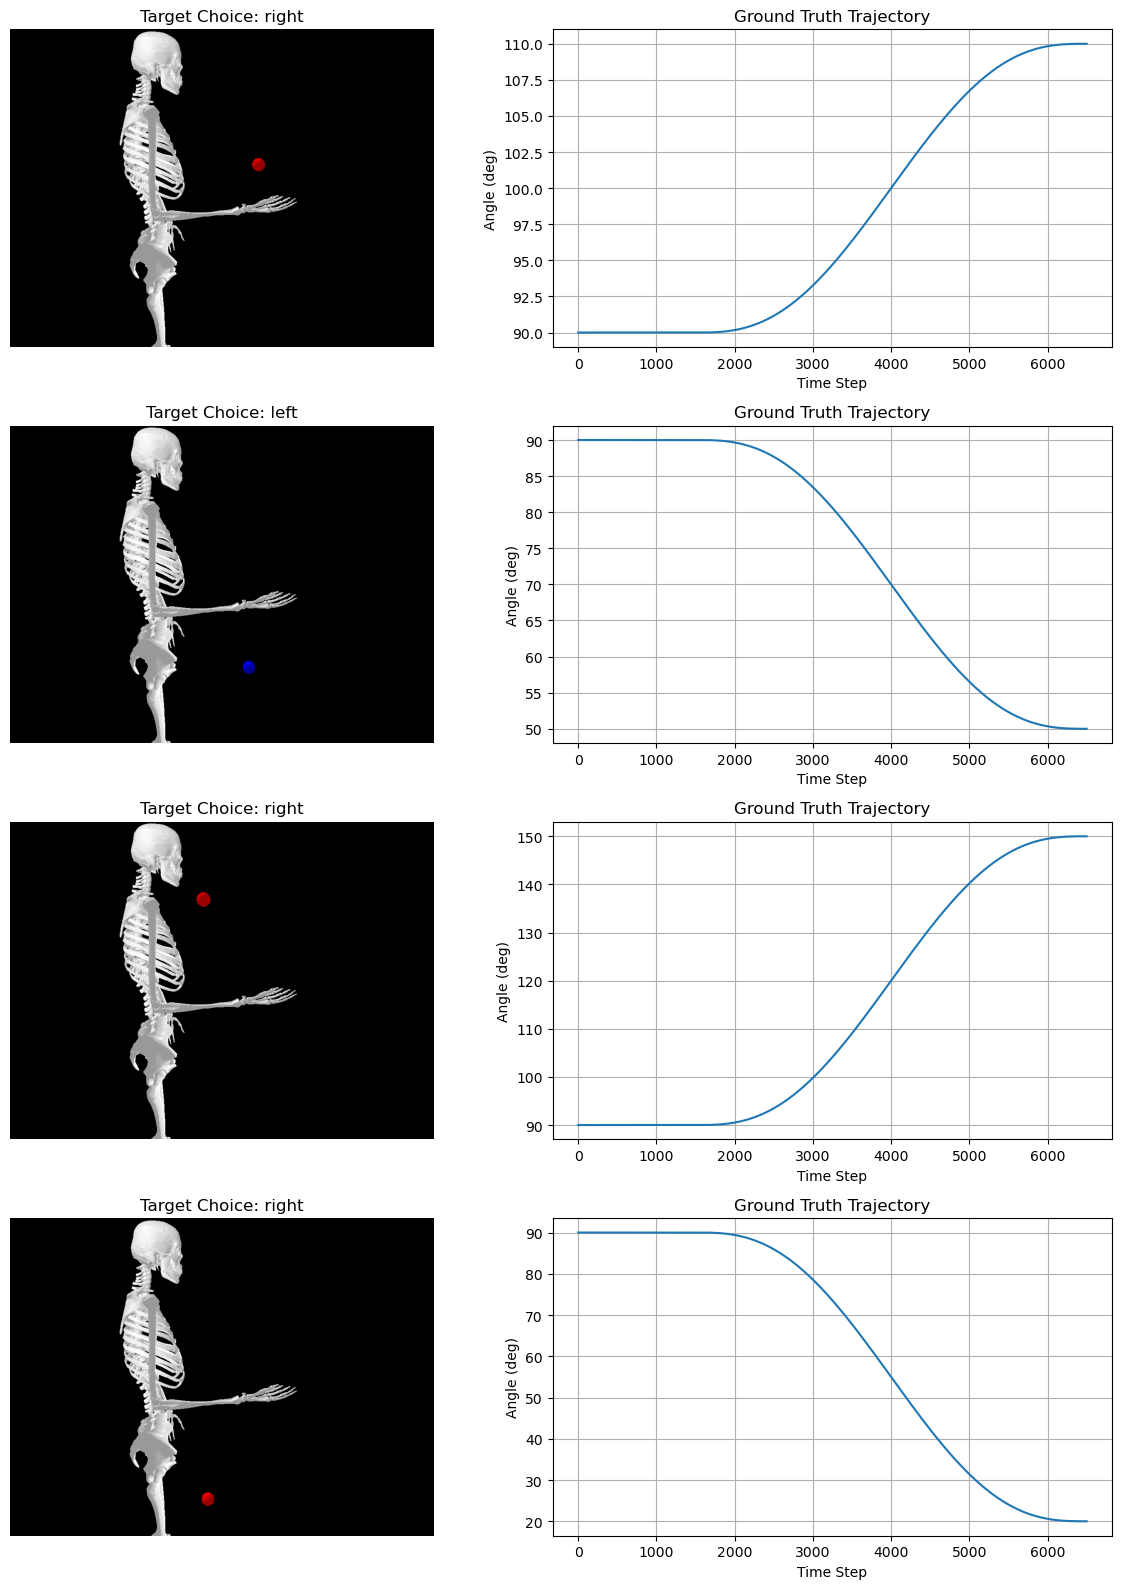

In [3]:
dataset = RobotArmDataset(data_dir=str(DATA_DIR), params=params, transform=transforms.Compose([
    transforms.Resize(params.image_size), transforms.ToTensor()
]))

if len(dataset) == 0:
    sys.exit(f"ERROR: No data found in {DATA_DIR}. Exiting.")

print(f"Loaded {len(dataset)} samples. Trajectory length: {params.trajectory_length}")

# --- Visualize a few data samples ---
print("\nVisualizing a few data samples...")
num_samples_to_show = min(len(dataset), 4)
fig, axes = plt.subplots(num_samples_to_show, 2, figsize=(12, 4 * num_samples_to_show))
if num_samples_to_show == 1: axes = [axes] # make it iterable

for i in range(num_samples_to_show):
    item = dataset.task_data[i]
    image = Image.open(item['image_path'])
    trajectory_rad = item['ground_truth_trajectory_rad']
    choice = item['target_choice']

    # Plot image
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f"Target Choice: {choice}")
    axes[i, 0].axis('off')

    # Plot trajectory
    axes[i, 1].plot(np.rad2deg(trajectory_rad))
    axes[i, 1].set_title("Ground Truth Trajectory")
    axes[i, 1].set_xlabel("Time Step")
    axes[i, 1].set_ylabel("Angle (deg)")
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()

## 4. Training

Now we'll train the model. We create a DataLoader, initialize the network, optimizer, and loss functions, and then run the training loop.


--- Starting Training for ANN Planner ---
Training on device 'cpu'...
Epoch   1/500 | Total Loss: 3.064230 | Traj Loss: 2.371104 | Choice Loss: 0.693126
Epoch  10/500 | Total Loss: 0.910213 | Traj Loss: 0.222600 | Choice Loss: 0.687613
Epoch  20/500 | Total Loss: 0.924112 | Traj Loss: 0.220102 | Choice Loss: 0.704010
Epoch  30/500 | Total Loss: 0.900980 | Traj Loss: 0.224995 | Choice Loss: 0.675985
Epoch  40/500 | Total Loss: 0.854166 | Traj Loss: 0.188802 | Choice Loss: 0.665364
Epoch  50/500 | Total Loss: 0.809237 | Traj Loss: 0.167582 | Choice Loss: 0.641654
Epoch  60/500 | Total Loss: 0.716376 | Traj Loss: 0.152087 | Choice Loss: 0.564290
Epoch  70/500 | Total Loss: 0.563271 | Traj Loss: 0.133233 | Choice Loss: 0.430037
Epoch  80/500 | Total Loss: 0.398168 | Traj Loss: 0.114494 | Choice Loss: 0.283675
Epoch  90/500 | Total Loss: 0.277824 | Traj Loss: 0.096191 | Choice Loss: 0.181633
Epoch 100/500 | Total Loss: 0.205624 | Traj Loss: 0.078811 | Choice Loss: 0.126813
Epoch 110/500 | 

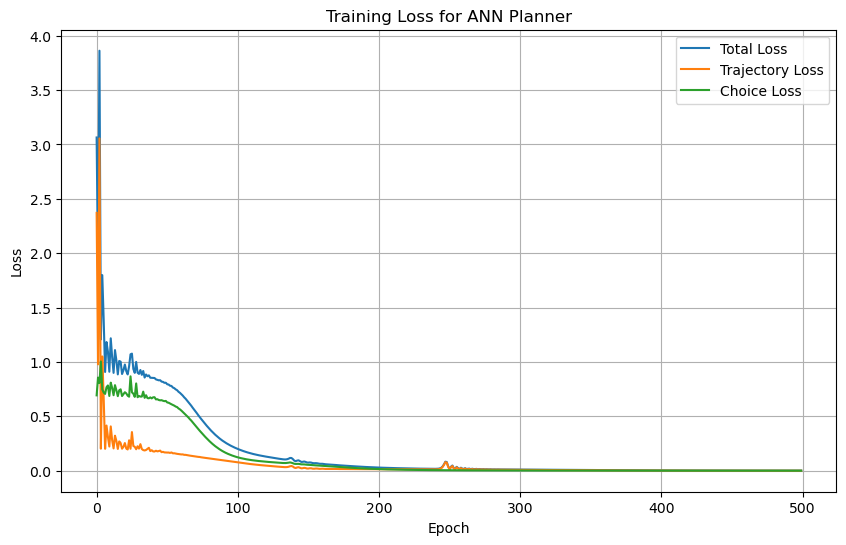

In [4]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=True)

if params.model_type == 'ann':
    net = ANNPlannerNet(params=params).to(device)
else: # gle
    net = GLEPlannerNet(params=params).to(device)

optimizer = optim.Adam(net.parameters(), lr=params.learning_rate)
criterion_trajectory = nn.MSELoss()
criterion_choice = nn.CrossEntropyLoss()

loss_history, traj_loss_history, choice_loss_history = [], [], []

print(f"\n--- Starting Training for {params.model_type.upper()} Planner ---")
print(f"Training on device '{device}'...")

for epoch in range(params.num_epochs):
    net.train()
    running_loss, running_traj_loss, running_choice_loss = 0.0, 0.0, 0.0

    for images, true_trajectory, target_choice_idx in train_loader:
        images, true_trajectory, target_choice_idx = images.to(device), true_trajectory.to(device), target_choice_idx.to(device)
        optimizer.zero_grad()

        if params.model_type == 'ann':
            output = net(images)
            trajectory_loss = criterion_trajectory(output[:, :params.trajectory_length], true_trajectory)
            choice_loss = criterion_choice(output[:, params.trajectory_length:], target_choice_idx)
            total_loss = trajectory_loss + choice_loss
            total_loss.backward()
            optimizer.step()
        else: # gle
            target = torch.cat((true_trajectory, torch.nn.functional.one_hot(target_choice_idx, num_classes=params.num_choices)), dim=1)
            for _ in range(params.gle_update_steps):
                output = net(images, target, beta=params.gle_beta)
            optimizer.step()
            trajectory_loss = criterion_trajectory(output[:, :params.trajectory_length], true_trajectory)
            choice_loss = criterion_choice(output[:, params.trajectory_length:], target_choice_idx)
            total_loss = trajectory_loss + choice_loss

        running_loss += total_loss.item()
        running_traj_loss += trajectory_loss.item()
        running_choice_loss += choice_loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_traj_loss = running_traj_loss / len(train_loader)
    epoch_choice_loss = running_choice_loss / len(train_loader)

    loss_history.append(epoch_loss); traj_loss_history.append(epoch_traj_loss); choice_loss_history.append(epoch_choice_loss)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1: >3}/{params.num_epochs} | Total Loss: {epoch_loss:.6f} | Traj Loss: {epoch_traj_loss:.6f} | Choice Loss: {epoch_choice_loss:.6f}")

print("\n--- Training Finished ---")
model_save_path = MODELS_DIR / f"trained_{params.model_type}_planner.pth"
torch.save(net.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Plotting training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Total Loss'); plt.plot(traj_loss_history, label='Trajectory Loss'); plt.plot(choice_loss_history, label='Choice Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'Training Loss for {params.model_type.upper()} Planner'); plt.legend(); plt.grid(True)
loss_plot_path = RESULTS_DIR / f'{params.model_type}_planner_training_loss.png'
plt.savefig(loss_plot_path)
print(f"Training plot saved to {loss_plot_path}")
plt.show()

## 5. Evaluation

With the model trained, we can now evaluate its performance. We will load the saved model and run it on the dataset to calculate choice and final angle accuracy.

In [5]:
print(f"\n--- Starting Evaluation for {params.model_type.upper()} Planner ---")

# The dataset is already loaded, but we need a version without ToTensor for visualization
eval_dataset = RobotArmDataset(data_dir=str(DATA_DIR), params=params)

if params.model_type == 'ann':
    net = ANNPlannerNet(params=params)
    planner = ANNPlanner(params=params, net=net)
else: # gle
    net = GLEPlannerNet(params=params)
    planner = GLEPlanner(params=params, net=net)

model_path = MODELS_DIR / f"trained_{params.model_type}_planner.pth"
try:
    planner.load_model(model_path)
except FileNotFoundError:
    sys.exit(f"ERROR: Model not found at {model_path}. Please train it first.")

correct_choices, correct_angles = 0, 0
predicted_trajectories = []

for item_metadata in eval_dataset.task_data:
    image_path = Path(item_metadata['image_path'])

    predicted_trajectory, predicted_choice = planner.image_to_trajectory(image_path)
    predicted_trajectories.append(predicted_trajectory)

    if predicted_choice == item_metadata['target_choice']:
        correct_choices += 1
    if np.isclose(predicted_trajectory[-1], item_metadata['ground_truth_trajectory_rad'][-1], atol=np.deg2rad(1.0)):
        correct_angles += 1

choice_accuracy = (correct_choices / len(eval_dataset)) * 100
angle_accuracy = (correct_angles / len(eval_dataset)) * 100
print(f"\n--- Evaluation Complete ---")
print(f"Choice Accuracy: {choice_accuracy:.2f}%")
print(f"Final Angle Accuracy (within 1 degree): {angle_accuracy:.2f}%")


--- Starting Evaluation for ANN Planner ---
Loading trained model from /home/paul/dev/controller/submodules/pfc_planner/models/trained_ann_planner.pth to device 'cpu'...

--- Evaluation Complete ---
Choice Accuracy: 100.00%
Final Angle Accuracy (within 1 degree): 84.38%


## 6. Result Visualization

Finally, let's visualize the trajectories predicted by the model against the ground truth for a few samples.


Visualizing predicted trajectories...


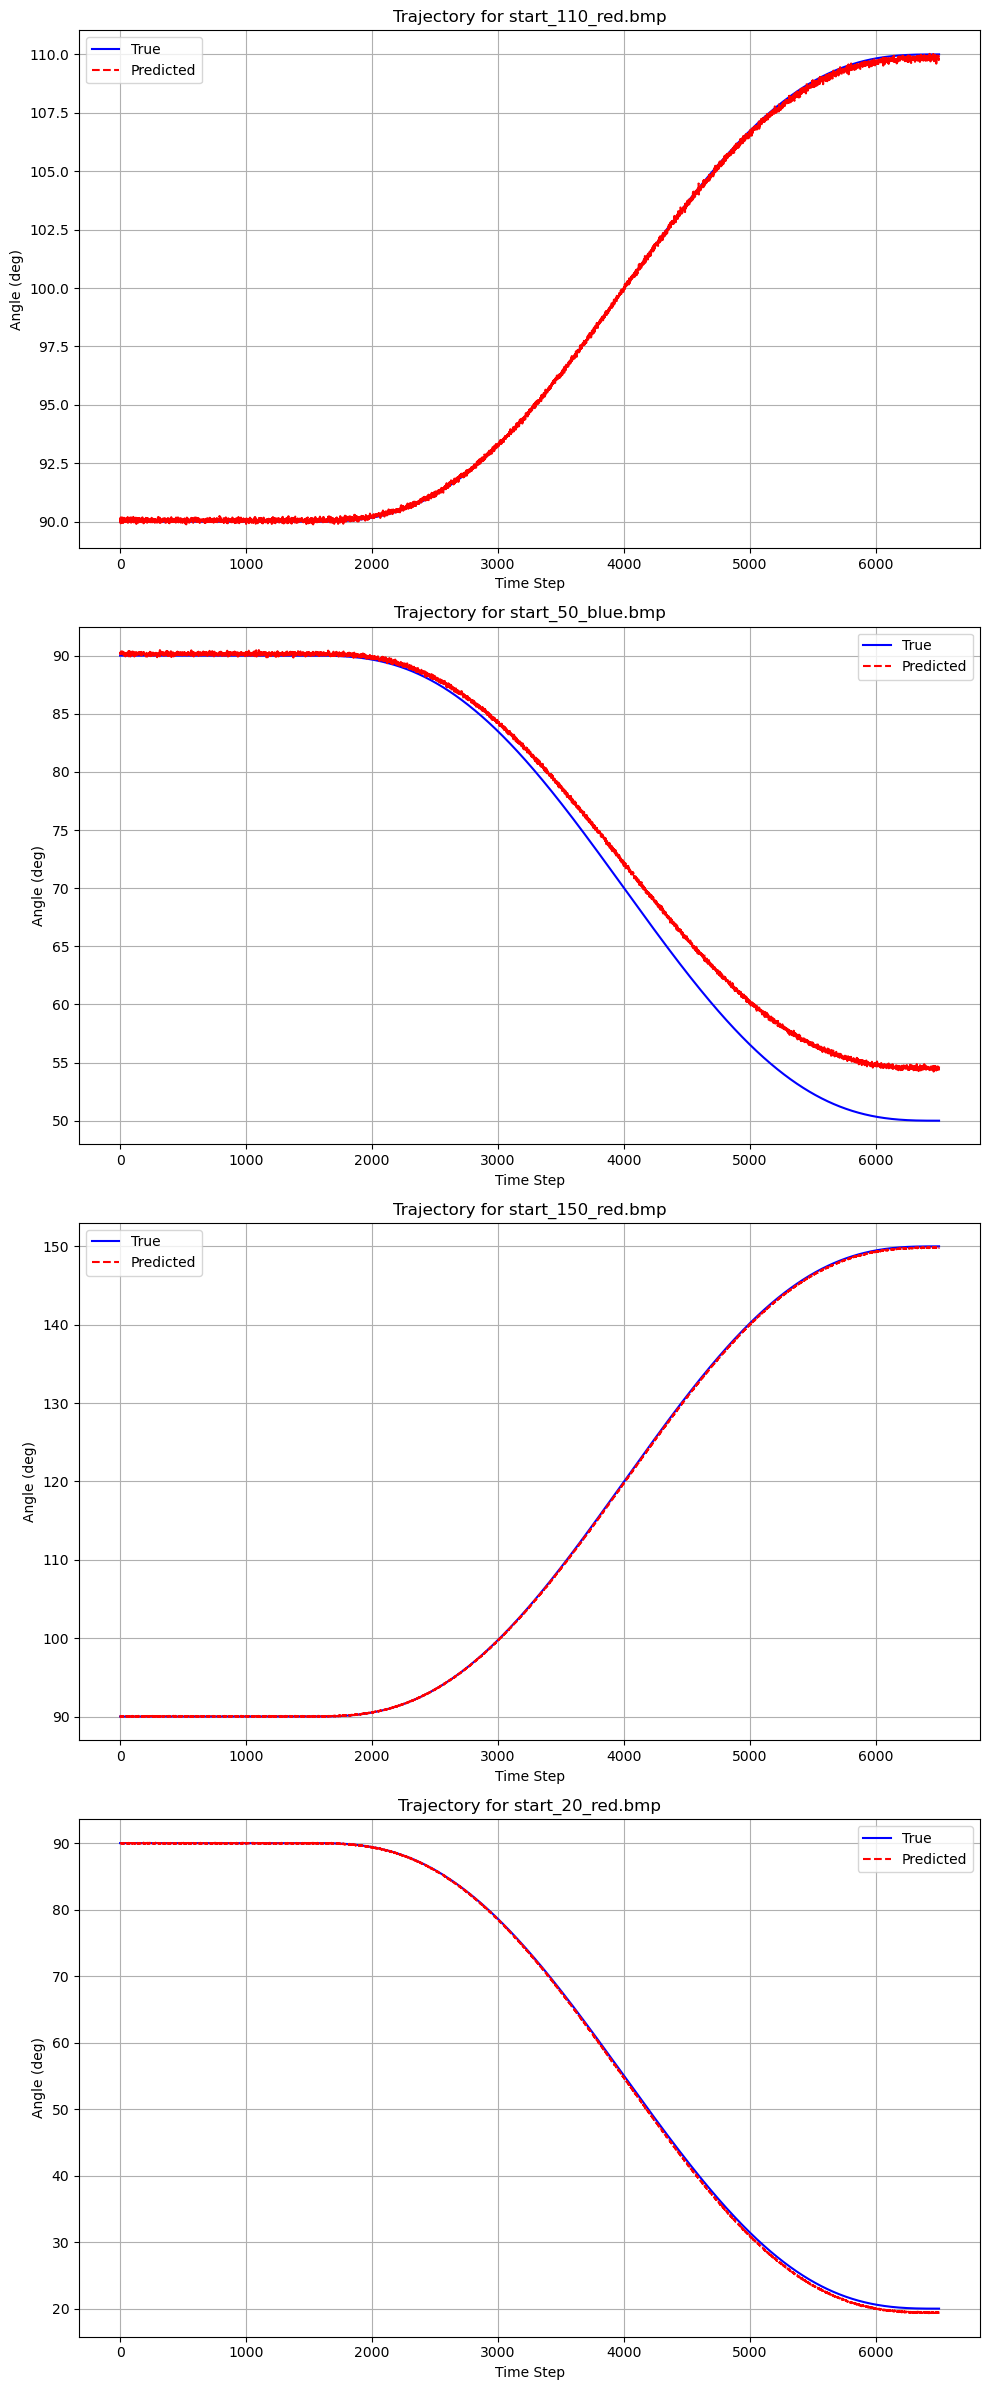


Trajectory plots saved to '/home/paul/dev/controller/submodules/pfc_planner/results'


In [6]:
print("\nVisualizing predicted trajectories...")
num_plots_to_show = min(len(eval_dataset), 4)
fig, axes = plt.subplots(num_plots_to_show, 1, figsize=(10, 6 * num_plots_to_show))
if num_plots_to_show == 1: axes = [axes]

for i in range(num_plots_to_show):
    item_metadata = eval_dataset.task_data[i]
    image_path = Path(item_metadata['image_path'])
    true_trajectory = item_metadata['ground_truth_trajectory_rad']
    predicted_trajectory = predicted_trajectories[i]

    ax = axes[i]
    ax.plot(np.rad2deg(true_trajectory), label='True', color='blue')
    ax.plot(np.rad2deg(predicted_trajectory), label='Predicted', color='red', linestyle='--')
    ax.set_title(f"Trajectory for {image_path.name}")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Angle (deg)")
    ax.legend()
    ax.grid(True)
    
    # Save individual plots as well
    fig_single = plt.figure(figsize=(10, 6))
    plt.plot(np.rad2deg(true_trajectory), label='True', color='blue')
    plt.plot(np.rad2deg(predicted_trajectory), label='Predicted', color='red', linestyle='--')
    plt.title(f"Trajectory for {image_path.name}"); plt.xlabel("Time Step"); plt.ylabel("Angle (deg)")
    plt.legend(); plt.grid(True)
    plot_save_path = RESULTS_DIR / f"{image_path.stem}_trajectory.png"
    plt.savefig(plot_save_path)
    plt.close(fig_single)


plt.tight_layout()
plt.show()

print(f"\nTrajectory plots saved to '{RESULTS_DIR.resolve()}'")